# Models 10
*Anders Poirel*

In [1]:
cd ..

C:\Users\Anders\Documents\data-science-projects\dss-diseasespread


In [2]:
import numpy as np
import pandas as pd 
import os 

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate, TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler 

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import NegativeBinomial

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from src.models.utilities import build_submission

In [3]:
from progestimator.prog_regression import ProgressiveRegression

In [4]:
mpl.rcParams.update({
    'figure.autolayout': True,
    'figure.dpi': 150
})
sns.set()

## Reading the data

In [5]:
DATA_PATH = 'data/processed'
PRED_PATH = 'models'

In [6]:
X_train = pd.read_csv(os.path.join(DATA_PATH, 'lag52_train_features.csv'))
X_test = pd.read_csv(os.path.join(DATA_PATH, 'lag52_test_features.csv'))
y_train = pd.read_csv(os.path.join(DATA_PATH, 'lag52_train_labels.csv'))

In [7]:
X_train_sj = X_train[X_train['city'] == 'sj'].drop('city', axis = 1)
X_train_iq = X_train[X_train['city'] == 'iq'].drop('city', axis = 1)

X_test_sj = X_test[X_test['city'] == 'sj'].drop('city', axis = 1)
X_test_iq = X_test[X_test['city'] == 'iq'].drop('city', axis = 1)

y_train_sj = y_train[y_train['city'] == 'sj']['total_cases'].astype('float')
y_train_iq = y_train[y_train['city'] == 'iq']['total_cases'].astype('float')

## Models

Wrapper to adapt the regressor to the statsmodels api (adapted from [stackoverflow](https://stackoverflow.com/questions/41045752/using-statsmodel-estimations-with-scikit-learn-cross-validation-is-it-possible/))

In [8]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ 
    A sklearn-style wrapper for statsmodels regressors 
    that calls a regularized fit
    """
    def __init__(self, model_class, alpha = 1, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
        self.alpha = alpha
        
        
    def fit(self, X, y):
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit_regularized(alpha = self.alpha)
        
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

## San Juan

In [9]:
model_sj = Pipeline([
    ('select', SelectKBest(f_regression, k = 100)),
    ('scale', StandardScaler()),
    ('nb', SMWrapper(NegativeBinomial, alpha = 150))  
])

In [10]:
cv_sj = cross_validate(
    estimator = model_sj,
    scoring = 'neg_mean_absolute_error',
    X = X_train_sj,
    y = y_train_sj,
    cv = TimeSeriesSplit(5),
    n_jobs = -1,
    verbose = 100
)
print(np.mean(cv_sj['test_score']))
print(np.std(cv_sj['test_score']))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.4s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.6s finished
-26.804550857183095
9.02712723318511


Results 



|$\alpha$ | MAE |
| --- | --- |
| 1 | 40  |
| 10 | 36 |
| 25 | 33 |
| 50 | 31 |
| 75 | 29 |
| 100 | 28 |
| 125 | 27.7 |
| 150 | 27.0 |
| 175 | 28.9 |
| 200 | 28.4 |
| 250 | 28.8 |
| 500 | 30.0 |
| 1000 | 32.3 |


C:\Users\Anders\Miniconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1016: RuntimeWarning: overflow encountered in exp
  return np.sum(-np.exp(XB) +  endog*XB - gammaln(endog+1))
C:\Users\Anders\Miniconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2566: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
C:\Users\Anders\Miniconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:2566: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4.959066335317311
            Iterations: 30
            Function evaluations: 36
            Gradient evaluations: 30


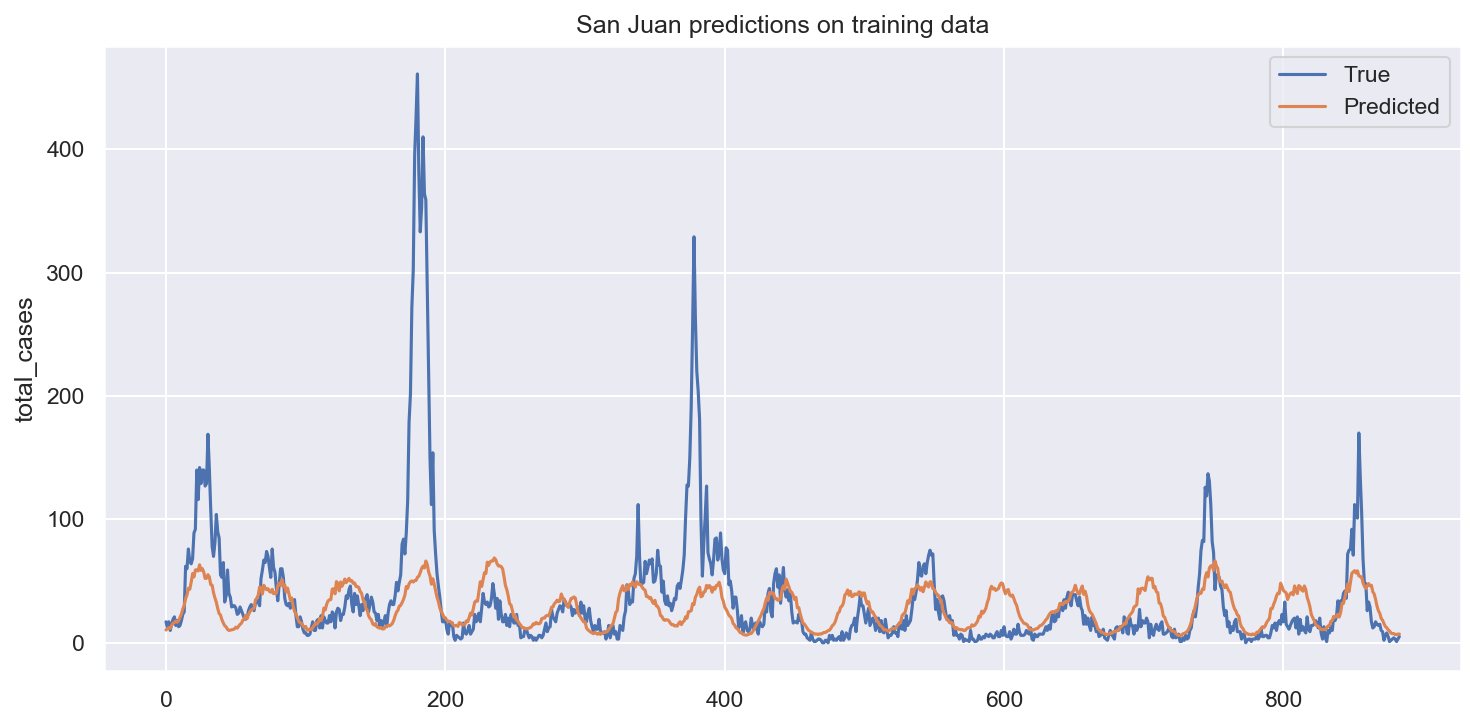

In [12]:
model_sj.fit(X_train_sj, y_train_sj)
y_pred_sj = model_sj.predict(X_train_sj)
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = y_train_sj, x = X_train_sj.index.values, ax = ax)
sns.lineplot(y = y_pred_sj, x = X_train_sj.index.values, ax = ax)
ax.set(title = 'San Juan predictions on training data')
ax.legend(['True', 'Predicted'])

### Iquitos

In [13]:
model_iq = Pipeline([
    ('select', SelectKBest(f_regression, k = 100)),
    ('scale', StandardScaler()),
    ('nb', SMWrapper(NegativeBinomial, alpha = 45))  
])

In [14]:
cv_iq = cross_validate(
    estimator = model_iq,
    X = X_train_iq,
    y = y_train_iq,
    cv = TimeSeriesSplit(5),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    verbose = 100
)
print(np.mean(cv_iq['test_score']))
print(np.std(cv_iq['test_score']))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.6s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.9s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.4s finished
-5.749225098127907
2.4455647162454666


In [15]:
cv_iq['test_score']

array([-2.04128666, -7.49758555, -4.57447019, -9.16115328, -5.47162982])

Results 


|$\alpha$ | MAE |
| --- | --- |
| 10 | 23.1 |
| 25 | 6.2 |
| 45 | 5.7 |
| 50 | 5.8 |
| 60 | 5.9 |
| 75 | 6.0 |
| 150 | 6.6 |


#### Visualization

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.276967131016594
            Iterations: 28
            Function evaluations: 33
            Gradient evaluations: 28


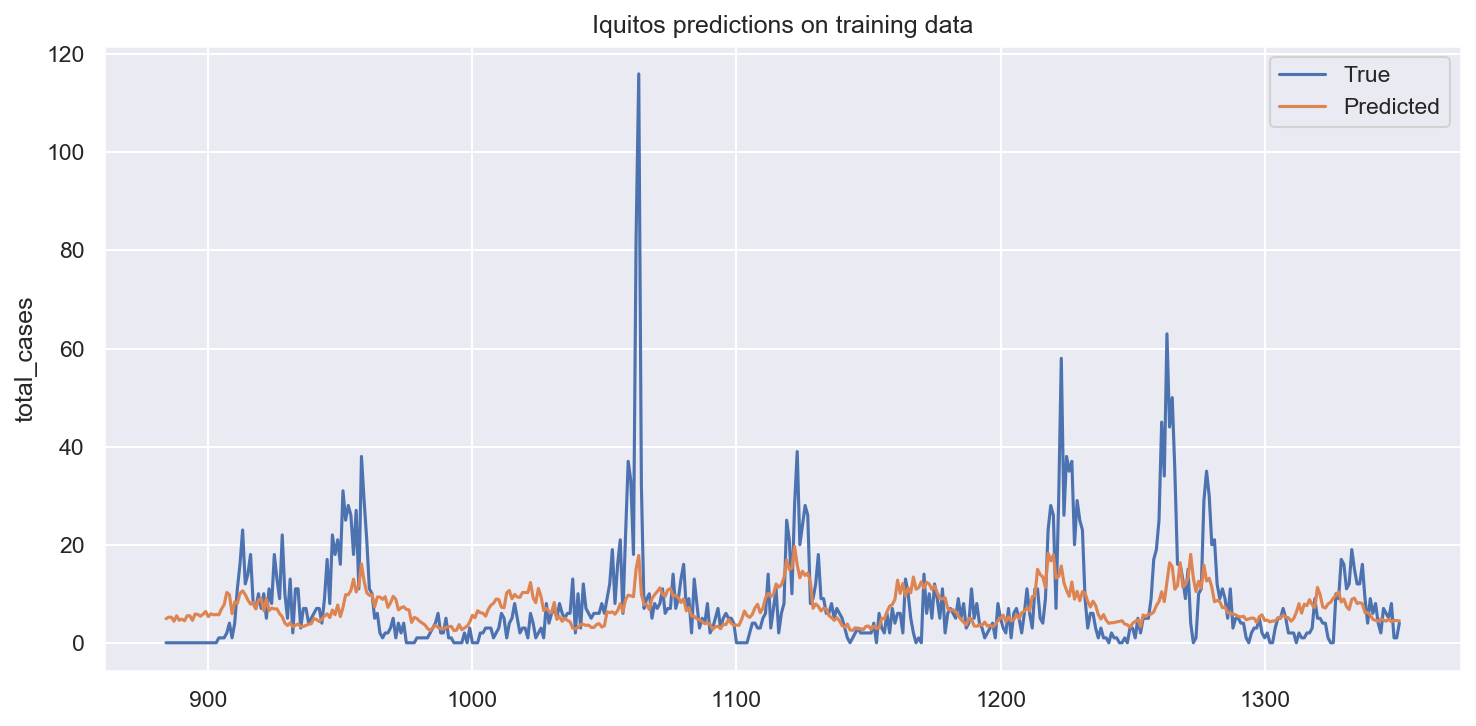

In [16]:
model_iq.fit(X_train_iq, y_train_iq)
y_val_iq = model_iq.predict(X_train_iq).flatten()
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(y = y_train_iq, x = X_train_iq.index.values, ax = ax)
sns.lineplot(y = y_val_iq, x = X_train_iq.index.values, ax = ax)
ax.set(title = 'Iquitos predictions on training data')
ax.legend(['True', 'Predicted'])

### Overall best performance

In [17]:
sj_ratio = len(X_train_sj) / len(X_train)
iq_ratio = len(X_train_iq) / len(X_train)

sj_ratio * np.mean(cv_sj['test_score']) + iq_ratio * np.mean(cv_iq['test_score'])

-19.51616886366399

This looks better than our previous best, so we try a submission

## Submission

In [18]:
PRED_PATH = 'models'

In [19]:
sub = build_submission(
    model_sj,
    model_iq,
    X_test_sj,
    X_test_iq,
    'data/raw',
    PRED_PATH,
    'lag52_negbin'
)

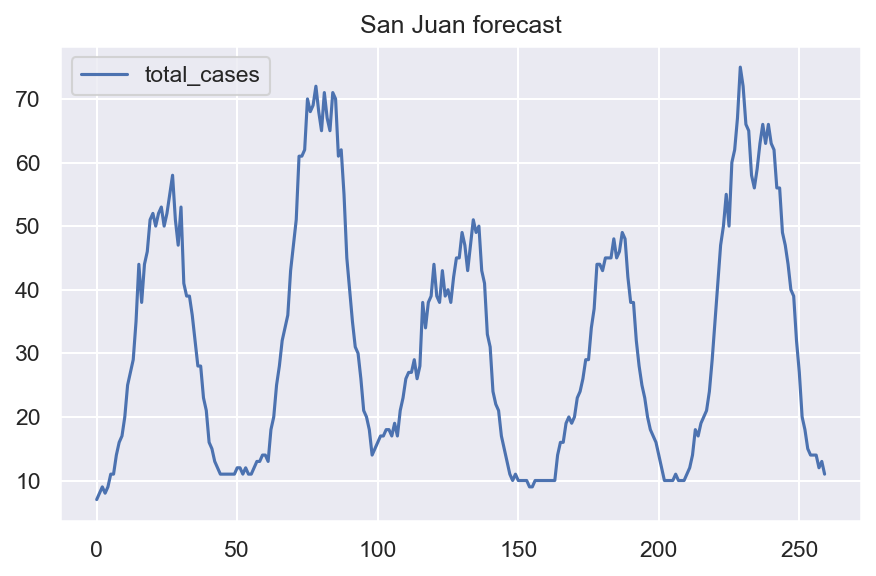

In [20]:
sub[sub['city'] == 'sj'].plot(
    y = 'total_cases',
    title = 'San Juan forecast'
)

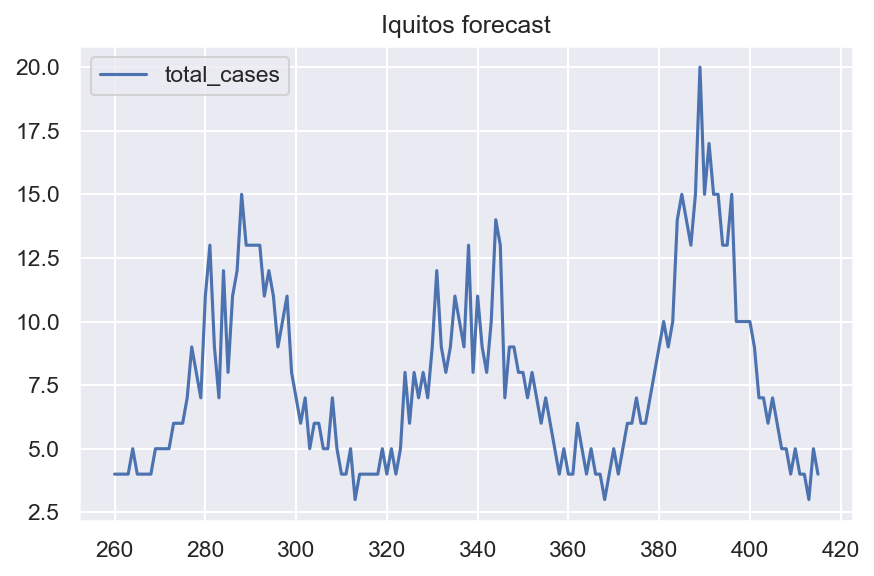

In [21]:
sub[sub['city'] == 'iq'].plot(
    y = 'total_cases',
    title = 'Iquitos forecast'
)

### Result

24.6 MAE, which is close to our best but not an actual improvement 😕